<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/FedAvg_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'
    %%capture output

UsageError: Line magic function `%capture` not found (But cell magic `%%capture` exists, did you mean that instead?).


## Imports

In [ ]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Thu May  6 09:03:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the CIFAR Dataset

In [ ]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_data_train = datasets.CIFAR10('./data/cifar10/', train=True, download=True, transform=transform_train)
cifar_data_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=transform_test)


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10/



Extracting ../data/cifar10/cifar-10-python.tar.gz to ../data/cifar10/


In [ ]:
classes = np.array(list(cifar_data_train.class_to_idx.values()))
classes_test = np.array(list(cifar_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [ ]:
print("Image Shape: {}".format(cifar_data_train.data[0].shape))

Image Shape: (32, 32, 3)


## Visualize Data

In [ ]:
def imshow(img):
	#img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='hsv') # convert from tensor to image

In [ ]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    #data = data.numpy()

    target = dataset.targets[i]
    #target = target.numpy()
    imshow(data)
    axis.set_title(target)


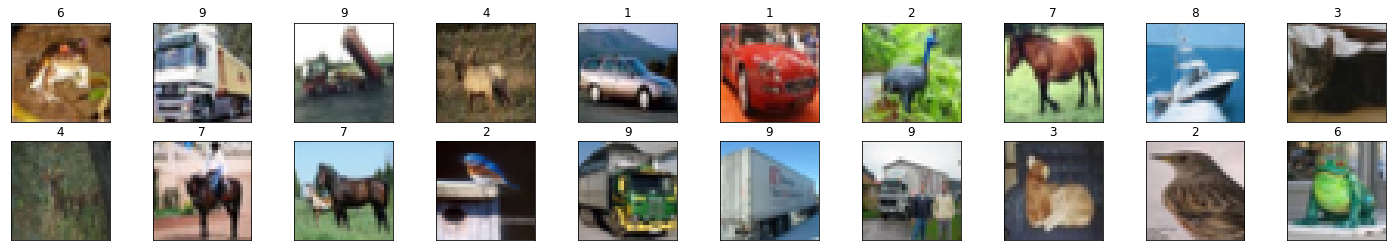

In [ ]:
visualize(cifar_data_train)

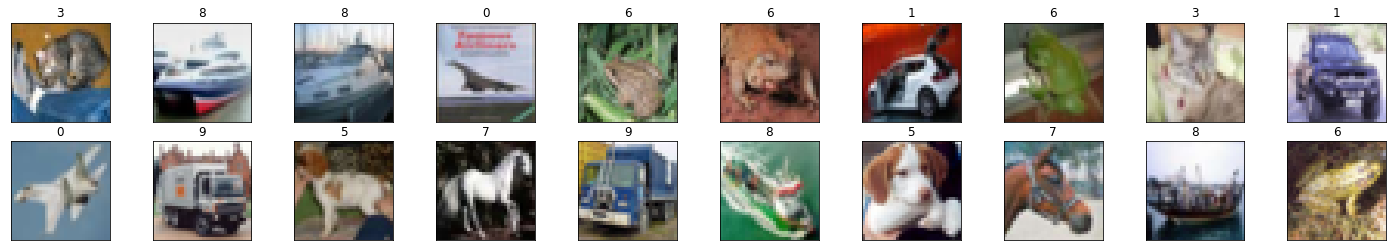

In [ ]:
visualize(cifar_data_test)

## Partitioning the Data (IID and non-IID)

In [ ]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the CIFAR Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [ ]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the CIFAR Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = np.array(dataset.targets)

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [ ]:
class CIFAR_MLP(nn.Module):
  def __init__(self):
    super(CIFAR_MLP, self).__init__()
    self.fc1 = nn.Linear(3 * 32 * 32, 2634)
    self.fc2 = nn.Linear(2634, 2196) 
    self.fc3 = nn.Linear(2196, 1758)
    self.fc4 = nn.Linear(1758, 1320)
    self.fc5 = nn.Linear(1320, 882)
    self.fc6 = nn.Linear(882, 444) 
    self.fc7 = nn.Linear(444, 10) 

  def forward(self, x):
    x = x.view(-1, 3 * 32 * 32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))

    x = self.fc7(x)
    return x

In [ ]:
class CIFAR_CNN(nn.Module):
  def __init__(self):
    super(CIFAR_CNN, self).__init__()

    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(4096, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, 10)
    )


  def forward(self, x):      
    # conv layers
    x = self.conv_layer(x)
    
    # flatten
    x = x.view(x.size(0), -1)
    
    # fc layer
    x = self.fc_layer(x)

    return x

### Print Model Summaries

In [ ]:
cifar_mlp = CIFAR_MLP()
cifar_cnn = CIFAR_CNN()

if torch.cuda.is_available():
  cifar_mlp.cuda()
  cifar_cnn.cuda()

print("CIFAR MLP SUMMARY")
print(summary(cifar_mlp, (32,32,3)))

print("\nCIFAR CNN SUMMARY")
print(summary(cifar_cnn, (3, 32,32)))

CIFAR MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2634]       8,094,282
            Linear-2                 [-1, 2196]       5,786,460
            Linear-3                 [-1, 1758]       3,862,326
            Linear-4                 [-1, 1320]       2,321,880
            Linear-5                  [-1, 882]       1,165,122
            Linear-6                  [-1, 444]         392,052
            Linear-7                   [-1, 10]           4,450
Total params: 21,626,572
Trainable params: 21,626,572
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 82.50
Estimated Total Size (MB): 82.58
----------------------------------------------------------------
None

CIFAR CNN SUMMARY
--------------------------------------------------------

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0
      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [ ]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, plt_title, plt_color, M=0.1):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()
  num_clients = K
  pk = np.ones(num_clients) * 1.0 / num_clients

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []


  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    newM = max(int(M*m), 1)
    
    c = 0
    S_t = np.random.choice(range(K), m, replace=False)

    for k in range(newM, len(S_t)):
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[S_t[k]])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      if c < int(m*M):
        for k in global_weights.keys():
          t = torch.Tensor(weights[k].shape).cuda()
          t.fill_(0.1)
          weights[k] = t
      
      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      c += 1


    target = copy.deepcopy(w[0]);
    weights_med = copy.deepcopy(w[0]);
    #x = 0
    for k in weights_med.keys():
      tmp = copy.deepcopy(torch.median(torch.stack([w[i][k].data for i in range(0, len(w))]), dim=0))[0]
      
      target[k].data = tmp
      
        #x += 1


      
    #print(type(w))
    #print(len(target))

    #print(type(target))
      

    global_weights = target

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)

  end = time.time()

  print(test_accuracy)
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()
  
  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end-start))
  
  return model, train_loss, test_accuracy, test_loss

## Testing Loop

In [ ]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))
  
  return test_accuracy, test_loss

## Logger

In [ ]:
log_dict = {}
NUM_REPEAT = 1

## CIFAR CNN on IID

### Train


Experiment Run Number:  0
Round: 1... 	Average Loss: 2.128
Round: 2... 	Average Loss: 2.029
Round: 3... 	Average Loss: 1.914
Round: 4... 	Average Loss: 1.827
Round: 5... 	Average Loss: 1.751
Round: 6... 	Average Loss: 1.678
Round: 7... 	Average Loss: 1.613
Round: 8... 	Average Loss: 1.552
Round: 9... 	Average Loss: 1.494
Round: 10... 	Average Loss: 1.437
[9.240506329113924, 29.240506329113924, 37.08860759493671, 42.65822784810127, 45.56962025316456, 47.59493670886076, 49.49367088607595, 51.139240506329116, 52.91139240506329, 54.68354430379747]


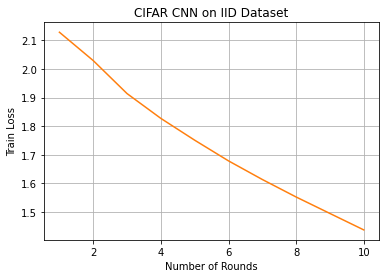

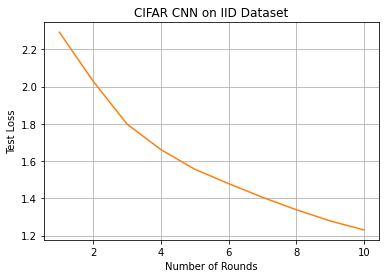

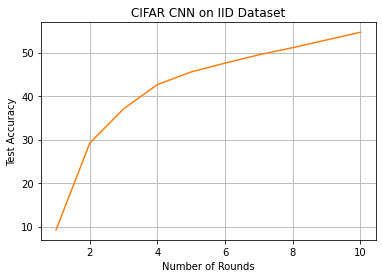

Training Done!
Total time taken to Train: 5206.663315534592


Test Loss: 1.230062

Test Accuracy of     0: 38% (28/72)
Test Accuracy of     1: 79% (62/78)
Test Accuracy of     2: 36% (32/87)
Test Accuracy of     3: 33% (27/80)
Test Accuracy of     4: 48% (35/72)
Test Accuracy of     5: 49% (36/73)
Test Accuracy of     6: 70% (63/89)
Test Accuracy of     7: 57% (45/78)
Test Accuracy of     8: 68% (59/86)
Test Accuracy of     9: 60% (45/75)

Final Test  Accuracy: 54.684 (432.0/790.0)


In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 10
  # client fraction
  C = 1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # data partition dictionary
  iid_dict = iid_partition(cifar_data_train, 100)
  # load model
  cifar_cnn = CIFAR_CNN()

  if torch.cuda.is_available():
    cifar_cnn.cuda()

  cifar_cnn_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_cnn, rounds, batch_size, lr, cifar_data_train, cifar_data_test, iid_dict, C, K, E, "CIFAR CNN on IID Dataset", "orange", 0.01)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

  criterion = nn.CrossEntropyLoss()
  acc, loss = testing(cifar_cnn_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

### Test

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['CIFAR CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## CIFAR CNN on Non IID

### Train


Experiment Run Number:  0
Round: 1... 	Average Loss: 0.583
Round: 2... 	Average Loss: 0.579
Round: 3... 	Average Loss: 0.542
Round: 4... 	Average Loss: 0.511
Round: 5... 	Average Loss: 0.477
Round: 6... 	Average Loss: 0.455
Round: 7... 	Average Loss: 0.437
Round: 8... 	Average Loss: 0.417
Round: 9... 	Average Loss: 0.41
Round: 10... 	Average Loss: 0.395
[10.126582278481013, 11.012658227848101, 11.012658227848101, 11.012658227848101, 12.405063291139241, 15.316455696202532, 20.759493670886076, 22.658227848101266, 25.063291139240505, 24.936708860759495]


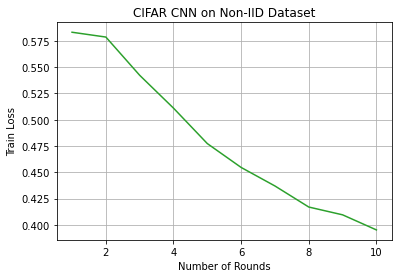

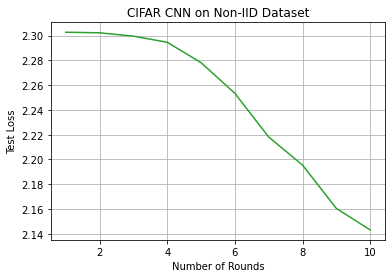

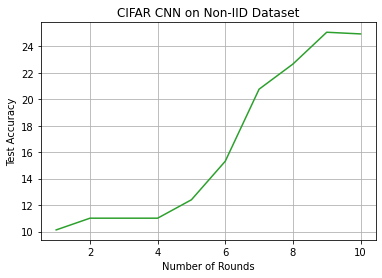

Training Done!
Total time taken to Train: 5169.84145450592


Test Loss: 2.143155

Test Accuracy of     0: 59% (43/72)
Test Accuracy of     1:  0% ( 0/78)
Test Accuracy of     2: 65% (57/87)
Test Accuracy of     3:  0% ( 0/80)
Test Accuracy of     4: 50% (36/72)
Test Accuracy of     5:  2% ( 2/73)
Test Accuracy of     6:  0% ( 0/89)
Test Accuracy of     7: 56% (44/78)
Test Accuracy of     8:  4% ( 4/86)
Test Accuracy of     9: 14% (11/75)

Final Test  Accuracy: 24.937 (197.0/790.0)


In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 10
  # client fraction
  C = 1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(cifar_data_train, 100, 200, 250, 2)
  # load model
  cifar_cnn = CIFAR_CNN()

  if torch.cuda.is_available():
    cifar_cnn.cuda()
 
  cifar_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_cnn, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, "CIFAR CNN on Non-IID Dataset", "green", 0.01)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

  criterion = nn.CrossEntropyLoss()
  acc, loss = testing(cifar_cnn_non_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

### Test

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['CIFAR CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## CIFAR MLP on IID

### Train

In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each round
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = iid_partition(cifar_data_train, 100)
  # load model
  cifar_mlp = CIFAR_MLP()

  if torch.cuda.is_available():
    cifar_mlp.cuda()

  cifar_mlp_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_mlp, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, "CIFAR MLP on IID Dataset", "orange", 0.01)
  
  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(cifar_mlp_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['CIFAR MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## CIFAR MLP on Non IID

### Train

In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 1
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(cifar_data_train, 100, 200, 250, 2)
  # load model
  cifar_mlp = CIFAR_MLP()

  if torch.cuda.is_available():
    cifar_mlp.cuda()

  cifar_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(cifar_mlp, rounds, batch_size, lr, cifar_data_train, cifar_data_test, data_dict, C, K, E, "CIFAR MLP on Non-IID Dataset", "green", 0.01)

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss

### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(cifar_mlp_non_iid_trained, cifar_data_test, 128, criterion, num_classes, classes_test, True)

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['CIFAR MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## Pickle Log

In [ ]:
import pickle

with open(path + 'Local_Round_FedMed.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [ ]:
log_dict

In [ ]:
import pickle

with open(path + 'Local_Round_FedMed.pkl', 'rb') as file:
  log_dict = pickle.load(file)

In [ ]:
print([test_acc[-1] for test_acc in log_dict['CIFAR CNN on IID']['test_accuracy']])

In [ ]:
print([test_acc[-1] for test_acc in log_dict['CIFAR CNN on Non IID']['test_accuracy']])

In [ ]:
print([test_acc[-1] for test_acc in log_dict['CIFAR MLP on IID']['test_accuracy']])

In [ ]:
print([test_acc[-1] for test_acc in log_dict['CIFAR MLP on Non IID']['test_accuracy']])